In [1]:
import kwant
import kwant.continuum as kct
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

from utils import pauli, interact, make_slab, plot_spectrum, plot_wfs, WSM_BC

%matplotlib inline
# %matplotlib qt

### Weyl Semimetal Tight-binding Hamiltonian

We start with a two-band effective Hamiltonian for a Weyl semimetal (WSM) [based on C. M. Wang et al., PRL **119**, 136806 (2017)]:
$$
H = A(k_x\sigma_x + k_y\sigma_y) + \left[M_0 - M_1 k_z^2 - M_2(k_x^2 + k_y^2)\right]\sigma_z + D_1 k_y^2 + D_2(k_x^2 + k_z^2).
$$
First, let's have a look at the spectrum of the bulk (infinite) system. We can plot it as a function of $k_z$ (note that the Weyl points lie along the $z$-direction).

In [2]:
H_Weyl = """
+ A * (k_x * sigma_x + k_y * sigma_y)
+ (M0 - M1 * k_z**2 - M2 * (k_x**2 + k_y**2)) * sigma_z
+ (D1 * k_y**2 + D2 * (k_x**2 + k_y**2)) * sigma_0
"""

HW_cont = kct.sympify(H_Weyl)
weyl_template = kct.discretize(HW_cont)

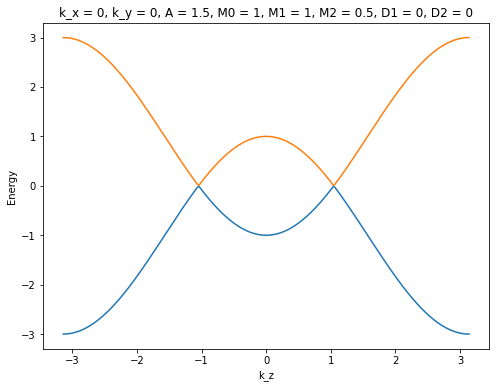

In [3]:
kx = ("k_x", 0)
ky = ("k_y", 0)
kz = ("k_z", np.linspace(-np.pi, np.pi, 300))


def WSM_spectrum(A, M0, M1, M2, D1, D2):
    params = dict(A=A, M0=M0, M1=M1, M2=M2, D1=D1, D2=D2)
    return plot_spectrum(syst=weyl_template, params=params, kx=kx, ky=ky, kz=kz)


WSM_spectrum(A=1.5, M0=1, M1=1, M2=0.5, D1=0, D2=0)

In [4]:
interact(WSM_spectrum, dict(A=1.5, M0=1, M1=1, M2=0.5, D1=0, D2=0), step_size=0.1)

interactive(children=(FloatText(value=1.5, description='A', step=0.1), FloatText(value=1.0, description='M0', …

We can also plot the spectrum as a function of two momenta, e.g., $k_x$ and $k_z$.

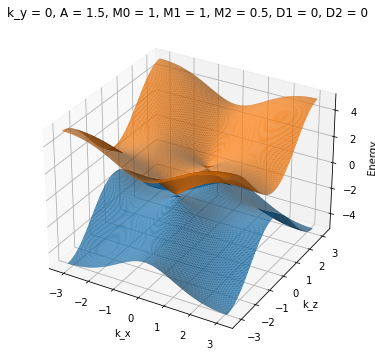

In [5]:
kx = ("k_x", np.linspace(-np.pi, np.pi, 200))
ky = ("k_y", 0)
kz = ("k_z", np.linspace(-np.pi, np.pi, 200))
WSM_spectrum(A=1.5, M0=1, M1=1, M2=0.5, D1=0, D2=0)
# interact(WSM_spectrum, dict(A=1.5, M0=1, M1=1, M2=0.5, D1=0, D2=0))

Now, let's inspect the spectrum of a finite WSM slab, which is cut in the $y$-direction. 

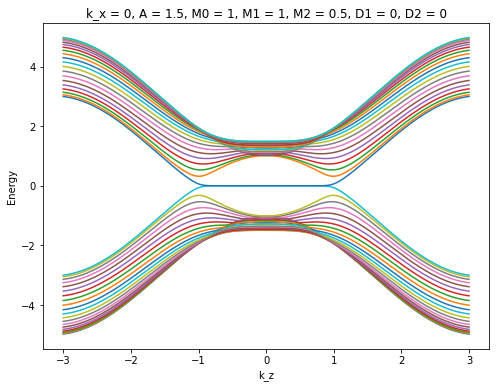

In [6]:
def WSM_finite(A, M0, M1, M2, D1, D2, L):
    params = dict(A=A, M0=M0, M1=M1, M2=M2, D1=D1, D2=D2)
    return plot_spectrum(
        syst=weyl_template, params=params, kx=kx, kz=kz, ts_dir="xz", L=L
    )


kx = ("k_x", 0)
kz = ("k_z", np.linspace(-3, 3, 200))
WSM_finite(A=1.5, M0=1, M1=1, M2=0.5, D1=0, D2=0, L=20)

Or an interactive version:

In [7]:
params = dict(A=1, M0=1.5, M1=1, M2=0.5, D1=0, D2=0)
interact(
    lambda A, M0, M1, M2, D1, D2: WSM_finite(A, M0, M1, M2, D1, D2, L=10),
    params,
    step_size=0.1,
)

interactive(children=(FloatText(value=1.0, description='A', step=0.1), FloatText(value=1.5, description='M0', …

The other thing we can inspect is how the wavefunction density corresponding to a particular band (at a fixed $\textbf k$-point) is distributed across the slab configuration. In particular, we can look at the two lowest eigenstates.

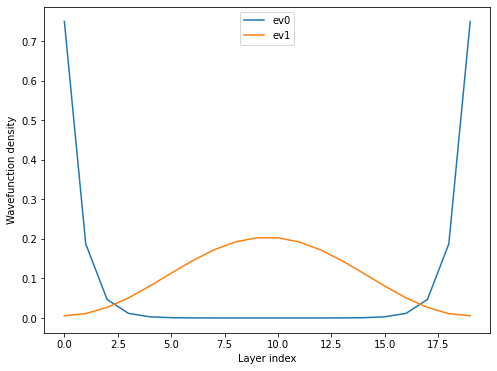

In [8]:
kx = ("k_x", 0)
kz = ("k_z", 0)
plot_wfs(weyl_template, params, kx=kx, kz=kz, L=20)

We see clearly that at $k_z = 0$, the lowest eigenstates reside primarily at the two surfaces of the slab, indicating that they correspond to the surface states. This is consistent with the spectrum above, where we can clearly see the Fermi arc states at $k_z = 0$. Now as we increase the value of $k_z$, we see that the lowest eigenstates gradually diffuse into the bulk, eventually leading to the disappearance of the surface states. 

In [9]:
def int_wfs(kz):
    kz = ("k_z", kz)
    plot_wfs(weyl_template, params, kx=kx, kz=kz, L=30)


interact(int_wfs, dict(kz=0), step_size=0.3)

interactive(children=(FloatText(value=0.0, description='kz', step=0.3), Output()), _dom_classes=('widget-inter…

Finally, we can compute the Berry curvature of a given set of bands as a function of $(k_x, k_z)$ with the `WSM_BC` function. Now that in this function, the bands are labelled from the lowest (negative) to the highest (positive) energy.

In [32]:
params = dict(A=1.5, M0=1, M1=1, M2=0.5, D1=0, D2=0)
ks = np.linspace(-np.pi, np.pi, 100)
band_indices = [0]

bc = WSM_BC(
    syst=weyl_template,
    params=params,
    ts_dir="yz",
    L=20,
    band_indices=band_indices,
    ks=ks,
)

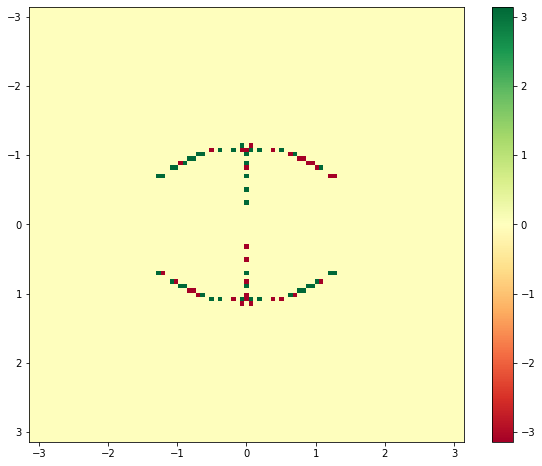

In [33]:
def plot_BC(bc, ks):
    plt.figure(figsize=(10, 8))
    vmax = max(np.abs(bc).min(), np.abs(bc).max())
    plt.imshow(
        bc,
        extent=(ks.min(), ks.max(), ks.max(), ks.min()),
        interpolation="none",
        cmap="RdYlGn",
        vmin=-vmax,
        vmax=vmax,
    )
    plt.colorbar()


plot_BC(bc, ks)

### Dirac Semimetal Tight-binding Hamiltonian
We begin with the DSM tight-binding Hamiltonian in $\textbf k$-space, which reads 
$$
\begin{equation*}
\begin{split}
    H_0(\textbf{k}) =&\ \varepsilon(\textbf k) + (m - t\cos k_x - t\cos k_y - t_3 \cos k_z)\sigma_z + t' (\sin k_x \sigma_x s_z - \sin k_y \sigma_y) \\
    & +t'_3 \sin k_z(\cos k_x - \cos k_y)\sigma_x s_x + 2t'_3 \sin k_z \sin k_x \sin k_y \sigma_x s_y
\end{split}
\end{equation*}
$$
in the basis $\Psi_{\textbf k}^\dagger = \left(c^\dagger_{1,\uparrow,\textbf k}, c^\dagger_{1,\downarrow,\textbf k}, c^\dagger_{2,\uparrow,\textbf k}, c^\dagger_{2,\downarrow,\textbf k}\right)$, where $\sigma_i$ and $s_i$ are Pauli matrices representing the orbital and spin degrees of freedom, respectively. For simplicity, we will take $\varepsilon(\textbf k) = 0$. This Hamiltonian has time-reversal symmetry, inversion symmetry, and $C_{4z}$-rotational symmetry, which ensure the stability of the two Dirac points on the $k_z$ axis. In order to generate the chiral-anomaly-induced nonlinear Hall (CNH) effect, we need to create an asymmetric Fermi surface around the $\Gamma$ point. To do that, we add the following three terms to the Hamiltonian $H_0(\textbf k)$: $2R (1 - \cos k_z)$ introducing tilting to the Dirac cones, $v_I \sin k_z\sigma_z s_z$ breaking the inversion symmetry, and $J_\text{ex} s_z$ breaking the time-reversal symmetry. The last term may be induced by an external magnetic field, i.e., the Zeeman splitting $J_z = \frac{1}{2}\tilde g\mu_B B_z$, with $\tilde g$ being the effective Lande factor.

This tight-binding model can be put on a three-dimensional cubic lattice, with 2 orbitals on each lattice site. By Fourier transform, we can obtain the following real-space Hamiltonian:
$$
\begin{equation*}
\begin{split}
    H = \sum_{\textbf r; \alpha\alpha'; s s'}& m c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r}(\sigma_z)_{\alpha\alpha'}\delta_{ss'} + 2R c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r}\delta_{\alpha\alpha'}\delta_{ss'} + J_\text{ex} c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r}\delta_{\alpha\alpha'}(s_z)_{ss'} \\
    & -\frac{t}{2}\left[c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf x}}(\sigma_z)_{\alpha\alpha'}\delta_{ss'} +c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf y}}(\sigma_z)_{\alpha\alpha'}\delta_{ss'} + \text{h.c.}\right] - \frac{t_3}{2}\left[c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf z}}(\sigma_z)_{\alpha\alpha'}\delta_{ss'} + \text{h.c.} \right] \\
    & +\frac{t'}{2}\left[-i c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf x}}(\sigma_x)_{\alpha\alpha'}(s_z)_{ss'} + i c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf y}}(\sigma_y)_{\alpha\alpha'}\delta_{ss'} +\text{h.c.} \right] \\
    & +\frac{t'_3}{4}\left[-i c^\dagger_{\alpha,s,\textbf r}(c_{\alpha',s',\textbf r+\hat{\textbf x}+\hat{\textbf z}} + c_{\alpha',s',\textbf r-\hat{\textbf x}+\hat{\textbf z}} - c_{\alpha',s',\textbf r+\hat{\textbf y}+\hat{\textbf z}} - c_{\alpha',s',\textbf r-\hat{\textbf y}+\hat{\textbf z}})(\sigma_x)_{\alpha\alpha'}(s_x)_{ss'} + \text{h.c.} \right] \\
    & +\frac{t'_3}{4}\left[-i c^\dagger_{\alpha,s,\textbf r}(c_{\alpha',s',\textbf r+\hat{\textbf x}-\hat{\textbf y}+\hat{\textbf z}} + c_{\alpha',s',\textbf r-\hat{\textbf x}+\hat{\textbf y}+\hat{\textbf z}} - c_{\alpha',s',\textbf r+\hat{\textbf x}+\hat{\textbf y}+\hat{\textbf z}} - c_{\alpha',s',\textbf r-\hat{\textbf x}-\hat{\textbf y}+\hat{\textbf z}})(\sigma_x)_{\alpha\alpha'}(s_y)_{ss'} + \text{h.c.} \right] \\
    & -R\left[c^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf z}}\delta_{\alpha\alpha'}\delta_{ss'} + \text{h.c.} \right] + \frac{v_I}{2}\left[-ic^\dagger_{\alpha,s,\textbf r}c_{\alpha',s',\textbf r+\hat{\textbf z}}(\sigma_z)_{\alpha\alpha'}(s_z)_{ss'} + \text{h.c.} \right].
\end{split}
\end{equation*}
$$
Moreover, to fully include the effect of the magnetic field, we also need to perform the *Peierls substitution* on all the hopping parameters, e.g.,
$$
t \to t\exp\left(-i\frac{e}{\hbar}\int \textbf A\cdot d\,\textbf l \right),
$$
where $\int \textbf A\cdot d\,\textbf l$ is the integral of the vector potential along the hopping path. One very convenient gauge for representing a homogeneous field $B\hat{\textbf z}$ is the Landau gauge: 
$$
\textbf A = -B y \hat{\textbf{x}}.
$$
We now construct the lattice model above in `kwant`.

In [12]:
# 4 orbitals per site: 2 spins * 2 orbitals
lat = kwant.lattice.cubic(1, norbs=4)
DSM_infinite = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
hoppings_xz = (((1, 0, 1), lat), ((-1, 0, 1), lat))
hoppings_yz = (((0, 1, 1), lat), ((0, -1, 1), lat))
hoppings_pxyz = (((1, -1, 1), lat), ((-1, 1, 1), lat))
hoppings_nxyz = (((1, 1, 1), lat), ((-1, -1, 1), lat))


def onsite(site, m, J, R):
    return m * pauli.szs0 + J * pauli.s0sz + 2 * R * pauli.s0s0


def hopx(site1, site2, t, tp, Bz):
    x1, y1, z1 = site1.pos
    x2, y2, z2 = site2.pos
    return (-0.5 * t * pauli.szs0 - 0.5j * tp * pauli.sxsz) * np.exp(
        -0.5j * Bz * (y1 + y2) * (x1 - x2)
    )


def hopy(site1, site2, t, tp):
    return -0.5 * t * pauli.szs0 + 0.5j * tp * pauli.sys0


def hopz(site1, site2, t3, R, vi):
    return -0.5 * t3 * pauli.szs0 - R * pauli.s0s0 - 0.5j * vi * pauli.szsz


# high-order hoppings
def hopxz(site1, site2, t3p, Bz):
    x1, y1, z1 = site1.pos
    x2, y2, z2 = site2.pos
    return (-0.25j * t3p * pauli.sxsx) * np.exp(-0.5j * Bz * (y1 + y2) * (x1 - x2))


def hopyz(site1, site2, t3p):
    return 0.25j * t3p * pauli.sxsx


def hop_pxyz(site1, site2, t3p, Bz):
    x1, y1, z1 = site1.pos
    x2, y2, z2 = site2.pos
    return (-0.25j * t3p * pauli.sxsy) * np.exp(-0.5j * Bz * (y1 + y2) * (x1 - x2))


def hop_nxyz(site1, site2, t3p, Bz):
    return 0.25j * t3p * pauli.sxsy


DSM_infinite[lat(0, 0, 0)] = onsite
DSM_infinite[kwant.HoppingKind((1, 0, 0), lat)] = hopx
DSM_infinite[kwant.HoppingKind((0, 1, 0), lat)] = hopy
DSM_infinite[kwant.HoppingKind((0, 0, 1), lat)] = hopz
DSM_infinite[[kwant.HoppingKind(*hopping) for hopping in hoppings_xz]] = hopxz
DSM_infinite[[kwant.HoppingKind(*hopping) for hopping in hoppings_yz]] = hopyz
DSM_infinite[[kwant.HoppingKind(*hopping) for hopping in hoppings_pxyz]] = hop_pxyz
DSM_infinite[[kwant.HoppingKind(*hopping) for hopping in hoppings_nxyz]] = hop_nxyz

Again, we can make a finite slab and inspect the energy spectrum.

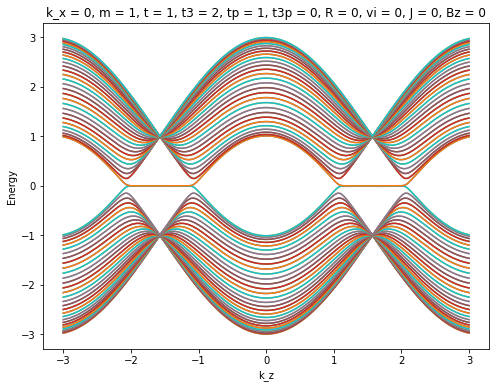

In [13]:
L = 30
kx = ("k_x", 0)
kz = ("k_z", np.linspace(-3, 3, 400))
params = dict(m=1, t=1, t3=2, tp=1, t3p=0, R=0, vi=0, J=0, Bz=0)

plot_spectrum(syst=DSM_infinite, params=params, kx=kx, kz=kz, ts_dir="xz", L=L)

In [14]:
# Interactive version
def DSM_spectrum(m, t, t3, tp, t3p, R, vi, J, Bz):
    params = dict(m=m, t=t, t3=t3, tp=tp, t3p=t3p, R=R, vi=vi, J=J, Bz=Bz)
    return plot_spectrum(
        syst=DSM_infinite, params=params, kx=kx, kz=kz, ts_dir="xz", L=L
    )


interact(DSM_spectrum, params, step_size=0.2)

interactive(children=(FloatText(value=1.0, description='m', step=0.2), FloatText(value=1.0, description='t', s…

One can see that as $m$ increases, the surface state topology seems to change, e.g., comparing $m=1$ with $m=3$ with other parameters fixed. This needs to be understood. 